# LRC Circuit

In [1]:
import jax
import jax.numpy as jnp
import diffrax

from circulus.components import Resistor, Capacitor, Inductor, VoltageSource
from circulus.compiler import compile_netlist, build_net_map
from circulus.solvers.transient import VectorizedTransientSolver
from circulus.solvers.strategies import DenseSolver
from circulus.netlist import draw_circuit_graph

import matplotlib.pyplot as plt

Compiling...
{'C1,p1': 1, 'L1,p2': 1, 'C1,p2': 0, 'V1,p2': 0, 'GND,p1': 0, 'R1,p2': 2, 'L1,p1': 2, 'V1,p1': 3, 'R1,p1': 3}
Total System Size: 6
Group: source_voltage
  Count: 1
  Var Indices Shape: (1, 3)
  Sample Var Indices:[[3 0 4]]
  Jacobian Rows Length: 1
Group: resistor
  Count: 1
  Var Indices Shape: (1, 2)
  Sample Var Indices:[[3 2]]
  Jacobian Rows Length: 1
Group: capacitor
  Count: 1
  Var Indices Shape: (1, 2)
  Sample Var Indices:[[1 0]]
  Jacobian Rows Length: 1
Group: inductor
  Count: 1
  Var Indices Shape: (1, 3)
  Sample Var Indices:[[2 1 5]]
  Jacobian Rows Length: 1
2. Solving DC Operating Point...
3. Running Simulation...


100.00%|██████████| [00:00<00:00, 2956.63%/s]


4. Plotting...


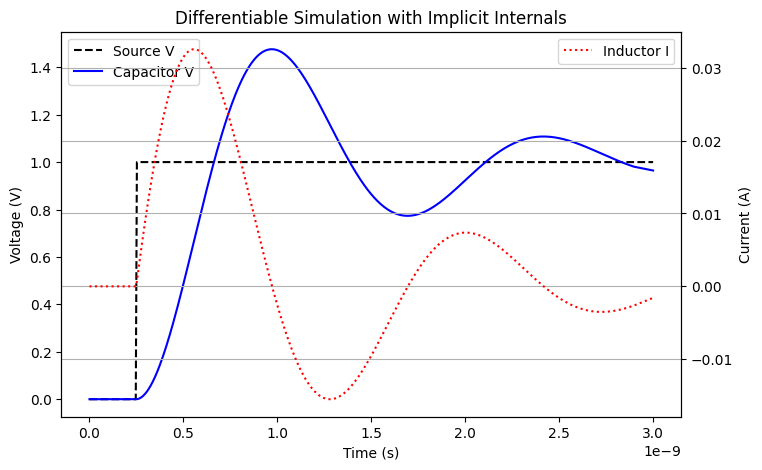

In [4]:
jax.config.update("jax_enable_x64", True)

t_max = 3E-9

models_map = {
    'resistor': Resistor,
    'capacitor': Capacitor,
    'inductor': Inductor,
    'source_voltage': VoltageSource,
    'ground': lambda: 0
}

net_dict = {
    "instances": {
        "GND": {"component":"ground"},
        "V1": {"component":"source_voltage", "settings":{"V": 1.0,"delay":0.25E-9}},
        "R1": {"component":"resistor", "settings":{"R": 10.0}},
        "C1": {"component":"capacitor", "settings":{"C": 1e-11}},
        "L1": {"component":"inductor", "settings":{"L": 5e-9}},
    },
    "connections": {
        "GND,p1": ("V1,p2", "C1,p2"),
        "V1,p1": "R1,p1",
        "R1,p2": "L1,p1",
        "L1,p2": "C1,p1",
    },
}

print("Compiling...")
groups, sys_size, port_map = compile_netlist(net_dict, models_map)

print(port_map)

print(f"Total System Size: {sys_size}")
for g_name, g in groups.items():
    print(f"Group: {g_name}")
    print(f"  Count: {g.var_indices.shape[0]}")
    print(f"  Var Indices Shape: {g.var_indices.shape}")
    print(f"  Sample Var Indices:{g.var_indices}")
    print(f"  Jacobian Rows Length: {len(g.jac_rows)}")

print("2. Solving DC Operating Point...")
linear_strat = DenseSolver.from_circuit(groups, sys_size, is_complex=False)

y_guess = jnp.zeros(sys_size)
y_op = linear_strat.solve_dc(groups,y_guess)

solver = VectorizedTransientSolver(linear_solver=linear_strat)
term = diffrax.ODETerm(lambda t, y, args: jnp.zeros_like(y))

saveat = diffrax.SaveAt(ts=jnp.linspace(0, t_max, 500))

print("3. Running Simulation...")
sol = diffrax.diffeqsolve(
    term, solver, t0=0.0, t1=t_max, dt0=1e-3*t_max, 
    y0=y_op, args=(groups, sys_size),
    saveat=saveat, max_steps=100000,
    progress_meter=diffrax.TqdmProgressMeter(refresh_steps=100)
)

ts = sol.ts
v_src = sol.ys[:, port_map["V1,p1"]]
v_cap = sol.ys[:, port_map["C1,p1"]]
i_ind = sol.ys[:, 5]

print("4. Plotting...")
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(ts, v_src, 'k--', label='Source V')
ax1.plot(ts, v_cap, 'b-', label='Capacitor V')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (V)')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(ts, i_ind, 'r:', label='Inductor I')
ax2.set_ylabel('Current (A)')
ax2.legend(loc='upper right')

plt.title("Differentiable Simulation with Implicit Internals")
plt.grid(True)
plt.show()